In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB

from sqlalchemy import extract  
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

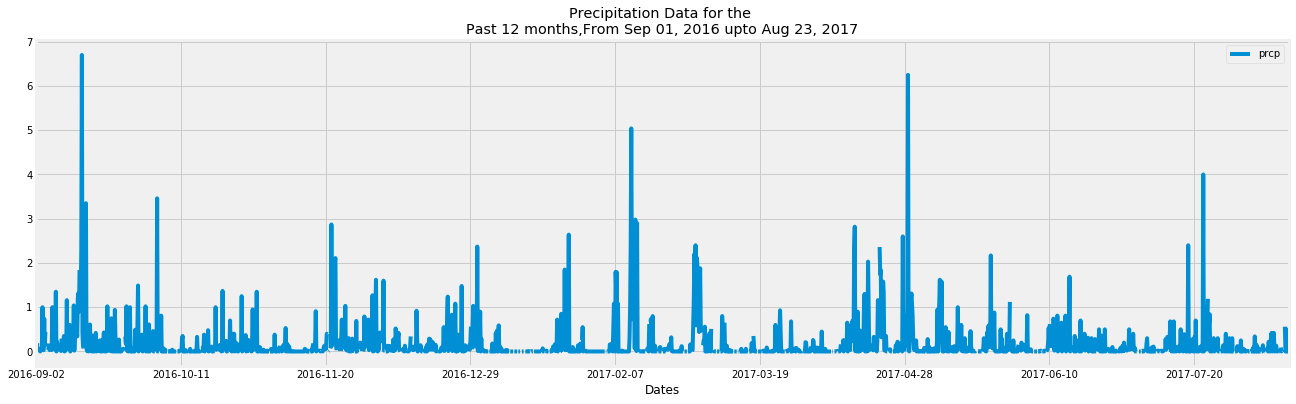

<Figure size 432x288 with 0 Axes>

In [11]:
### ANSWERS **********************************************************


from sqlalchemy import and_, func
from datetime import datetime

### Design a query to retrieve the last 12 months of precipitation data and plot the results

## Here is the query that gets the last 12 months from the data ***********
last_12_months = session.query(\
                         Measurement).distinct\
                        (extract("month",Measurement.date),\
                        extract("year",\
                                Measurement.date))\
                                .with_entities(\
                           extract("month",Measurement.date),\
                            extract("year",Measurement.date)).group_by(\
                            extract("month",Measurement.date),extract("year",\
                                    Measurement.date)).order_by(\
                                                                Measurement.date.desc()).all()   
## ****************
#getting the  12th month from the latest entry date of the data
(last_12_month_m,last_12_month_y) = [i for i in last_12_months][:12][-1]  # This is the month and year of the past 
                                                                         # 12 months 


dt_from = datetime(last_12_month_y, last_12_month_m, 1)  # We set the first day of the month for that date

#getting the latest date in the data
latest_data_date = (session.query(Measurement).order_by(Measurement.date.desc()))[0]  
dt_to = latest_data_date.date 

## We are filtering the data of measurements starting from the last pas 12 months up to the latest on the record
res = session.query(Measurement).filter(\
                                        and_(Measurement.date >= dt_from,\
                                             Measurement.date <=dt_to))\
                                        .order_by(Measurement.date)


# We then convert the sqlalchemy query to be used on the pandas dataframe

last_12months_data = pd.read_sql_query(res.statement, session.bind)
last_12months_data_plot = last_12months_data.plot(kind='line', figsize=(20,6),x='date',y='prcp')
last_12months_data_plot.set_xlabel("Dates")

plt.title("""Precipitation Data for the 
Past 12 months,From {0} upto {1}""".format(dt_from.strftime("%b %d, %Y"), \
                                                datetime.strptime(dt_to,"%Y-%m-%d").strftime("%b %d, %Y")))
plt.show()
plt.tight_layout()




In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#ANSWER

filtered_result = session.query(Measurement).filter(\
                                        and_(Measurement.date >= dt_from,\
                                             Measurement.date <=dt_to))\
                                        .with_entities(Measurement.date,\
                                                       Measurement.prcp.label("Precipitation")).order_by(Measurement.date)

last_12months_data = pd.read_sql_query(filtered_result.statement, session.bind)
(last_12months_data.describe())






,Precipitation
count,1963.000000
mean,0.171900
std,0.452315
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?

## ANSWER
total_station = session.query(Measurement).with_entities(\
              Measurement.station,func.count(Measurement.prcp).label("Total Data"))\
              .group_by("station").count()

print ("Total Station is {}".format(total_station))


Total Station is 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


## ANSWER
filtered_result = session.query(\
                                Measurement).with_entities(\
                                Measurement.station,func.count(Measurement.prcp).label("Total Data"))\
                                .group_by("station")\
                                .order_by(func.count(Measurement.prcp).desc())
    
pd.read_sql_query(filtered_result.statement, session.bind)



,station,Total Data
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


## ANSWER

filtered_result = session.query(\
                                Measurement).with_entities(\
                                Measurement.station,func.count(Measurement.prcp).label("Total Data"),\
                                func.min(Measurement.tobs).label("Lowest Temprature"),\
                                func.max(Measurement.tobs).label("Highest Temperature"),\
                                func.avg(Measurement.tobs).label("Average Temperature"))\
                                .group_by("station")\
                                .order_by(func.count(Measurement.prcp).desc())

pd.read_sql_query(filtered_result.statement, session.bind)



,station,Total Data,Lowest Temprature,Highest Temperature,Average Temperature
0,USC00519281,2772,54.0,85.0,71.663781
1,USC00513117,2696,59.0,85.0,72.689184
2,USC00519397,2685,56.0,87.0,74.553231
3,USC00519523,2572,56.0,85.0,74.543649
4,USC00516128,2484,58.0,84.0,70.915008
5,USC00514830,1937,58.0,85.0,74.873297
6,USC00511918,1932,53.0,87.0,71.615968
7,USC00517948,683,58.0,87.0,74.684402
8,USC00518838,342,58.0,83.0,72.724070


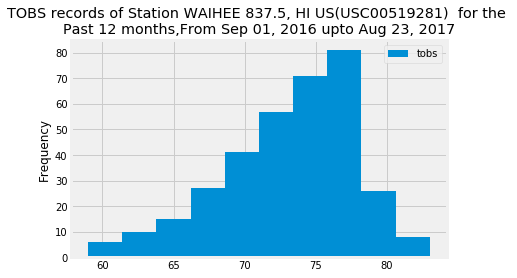

<Figure size 432x288 with 0 Axes>

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## ANSWER
res = session.query(Measurement).filter(\
                                        and_(Measurement.date >= dt_from,\
                                             Measurement.date <=dt_to,\
                                            Measurement.station =="USC00519281"))\
                                        .with_entities(Measurement.tobs)\
                                        .order_by(Measurement.date)

last_12months_data = pd.read_sql_query(res.statement, session.bind)

last_12months_data_plot = last_12months_data.plot.hist()

plt.title("""TOBS records of Station WAIHEE 837.5, HI US(USC00519281)  for the 
Past 12 months,From {0} upto {1}""".format(dt_from.strftime("%b %d, %Y"), \
                                                datetime.strptime(dt_to,"%Y-%m-%d").strftime("%b %d, %Y")))
plt.show()
plt.tight_layout()


![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-02-28', '2019-02-28')[0])


(58.0, 74.62264714669854, 87.0)


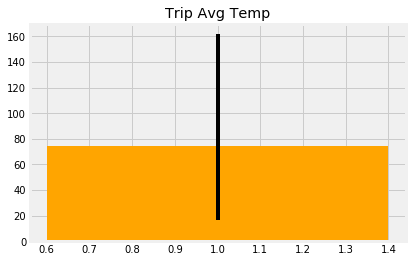

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin,tavg,tmax = calc_temps('2016-02-28', '2019-02-28')[0]
x = [1]
y = [tavg]

yerror = ([tmin], [tmax])

plt.title("Trip Avg Temp")
plt.bar(x,y,yerr=yerror, color='orange')
plt.show()



In [21]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


dt_from = datetime.strptime("2016-02-28","%Y-%m-%d")
dt_to = datetime.strptime("2019-02-28","%Y-%m-%d")

station_result = session.query(Station).join(Measurement,Station.station==Measurement.station)\
        .filter(and_(Measurement.date >= dt_from,\
                       Measurement.date <=dt_to))\
        .with_entities(Station.station,Station.name,Station.latitude, Station.longitude, \
                   Station.elevation, func.sum(Measurement.prcp)\
                   .label("Total Amount of Rainful"))\
        .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
pd.read_sql_query(station_result.statement, session.bind)


,station,name,latitude,longitude,elevation,Total Amount of Rainful
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,225.85
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,119.52
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,83.66
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,56.39
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,46.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,25.96
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,6.36


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date


## Answer : Daily normal calculation

#daily_normals("07-22")

#Starting and ending trip 01-July to 22-July

dt_from = datetime.strptime("2017-07-01","%Y-%m-%d") # start date of the trip
dt_to = datetime.strptime("2017-07-22","%Y-%m-%d") # end date of the trip

res = session.query(Measurement).filter(\
                                        and_(Measurement.date >= dt_from,\
                                             Measurement.date <=dt_to)).order_by(Measurement.date)

the_list = []

for r in res.all():
#    if (not (r.date[5:] in the_list)):
     the_list.append(r.date[5:])

# Loop through the list of %m-%d strings and calculate the normals for each date

the_calculated_normals = []
for l in the_list:
    the_calculated_normals.append((l,daily_normals(l)))

print (the_calculated_normals)


[('07-02', [(68.0, 75.40384615384616, 82.0)]), ('07-02', [(68.0, 75.40384615384616, 82.0)]), ('07-02', [(68.0, 75.40384615384616, 82.0)]), ('07-02', [(68.0, 75.40384615384616, 82.0)]), ('07-02', [(68.0, 75.40384615384616, 82.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-03', [(68.0, 75.32075471698113, 87.0)]), ('07-04', [(70.0, 76.57142857142857, 81.0)]), ('07-04', [(70.0, 76.57142857142857, 81.0)]), ('07-04', [(70.0, 76.57142857142857, 81.0)]), ('07-04', [(70.0, 76.57142857142857, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-05', [(66.0, 75.0, 81.0)]), ('07-06', [(69.0, 75.0, 81.0)]),

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

pandas_dataframe = pd.read_sql_query(res.statement, session.bind)
pandas_dataframe['trip_date'] = 'blank'
counter = 0

trip_dates = [i[0] for i in the_calculated_normals ]
the_min =  [i[1][0][0] for i in the_calculated_normals ]
the_avg =  [i[1][0][1] for i in the_calculated_normals ]
the_max =  [i[1][0][2] for i in the_calculated_normals ]

#print (the_min)

for j in  the_calculated_normals:    
    pandas_dataframe['trip_date'] = trip_dates
    pandas_dataframe['min'] = the_min
    pandas_dataframe['avg'] = the_avg
    pandas_dataframe['max'] = the_max
(pandas_dataframe)


,id,station,date,prcp,tobs,trip_date,min,avg,max
0,2675,USC00519397,2017-07-02,0.02,80.0,07-02,68.0,75.403846,82.0
1,5404,USC00513117,2017-07-02,0.05,77.0,07-02,68.0,75.403846,82.0
2,12141,USC00519523,2017-07-02,NaN,80.0,07-02,68.0,75.403846,82.0
3,14921,USC00519281,2017-07-02,0.15,81.0,07-02,68.0,75.403846,82.0
4,19499,USC00516128,2017-07-02,0.50,78.0,07-02,68.0,75.403846,82.0
5,2676,USC00519397,2017-07-03,0.04,78.0,07-03,68.0,75.320755,87.0
6,5405,USC00513117,2017-07-03,0.13,77.0,07-03,68.0,75.320755,87.0
7,7590,USC00514830,2017-07-03,NaN,81.0,07-03,68.0,75.320755,87.0
8,8991,USC00517948,2017-07-03,NaN,87.0,07-03,68.0,75.320755,87.0
9,12142,USC00519523,2017-07-03,0.02,81.0,07-03,68.0,75.320755,87.0


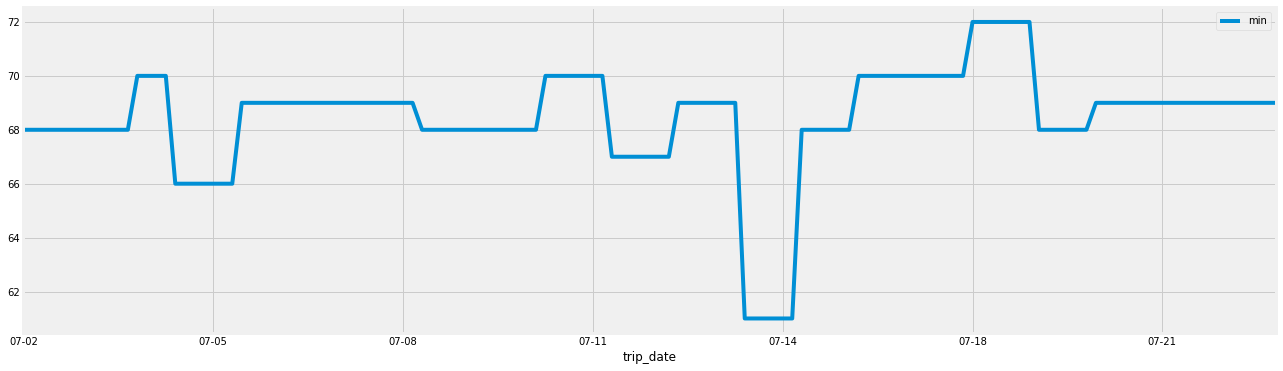

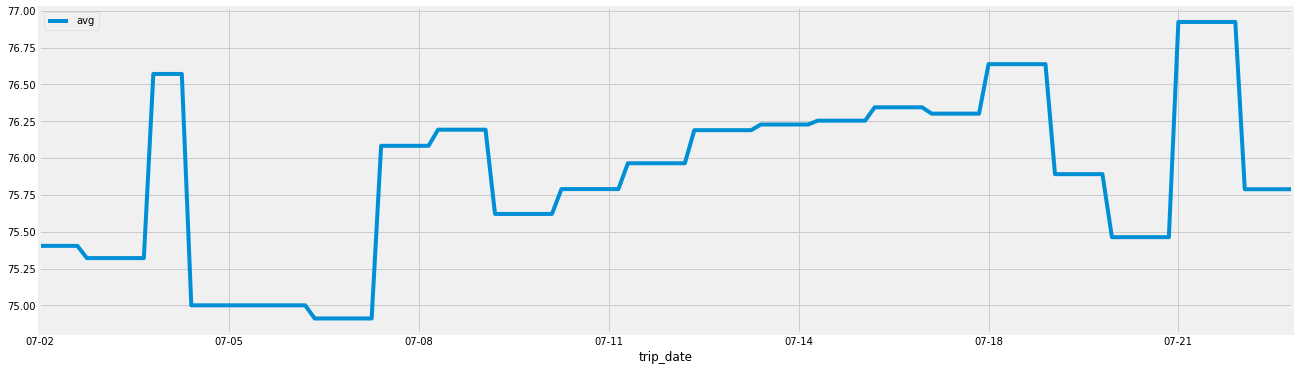

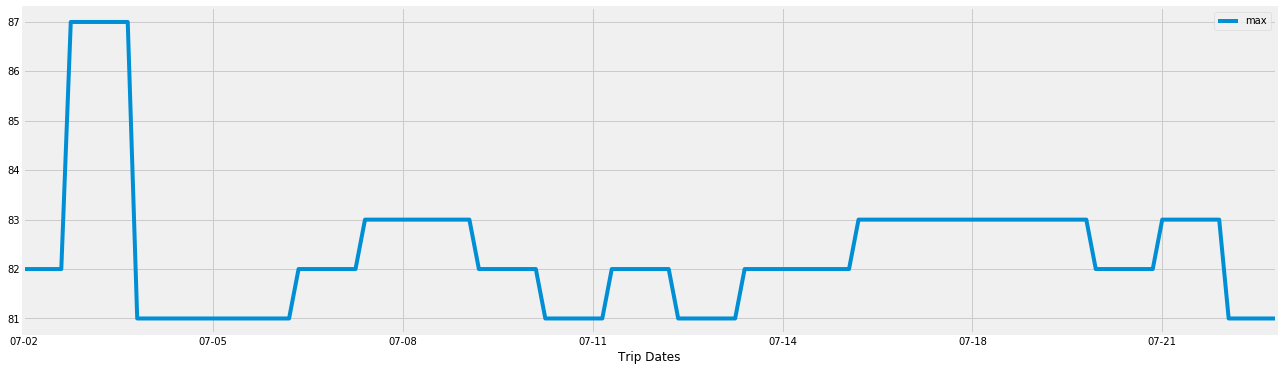

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the daily normals as an area plot with `stacked=False`





plot_daily_normal = pandas_dataframe.plot( figsize=(20,6),x='trip_date',y='min',stacked=False)
plot_daily_normal = pandas_dataframe.plot( figsize=(20,6),x='trip_date',y='avg',stacked=False)
plot_daily_normal = pandas_dataframe.plot( figsize=(20,6),x='trip_date',y='max',stacked=False)
plot_daily_normal.set_xlabel("Trip Dates")

                                              
plt.show()
plt.tight_layout()

